In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from energyflow.archs import EFN
from energyflow.utils import data_split

2023-08-08 23:15:45.255094: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def read_data(file_path):
    data_file = open(file_path)
    lno = 0
    pTvals = []
    etavals = []
    phivals = []
    tvals = []
    events_input=[]
    events_target=[]
    data = []

    for line in data_file:
        lno+=1
        if (lno > 1000000000):
            break
        # enumber = int(line.split()[0])
        isprime = int(line.split()[1])
        E = float(line.split()[2])
        px = float(line.split()[3])
        py = float(line.split()[4])
        pz = float(line.split()[5])
        t = float(line.split()[6])
        
        pT = math.sqrt( px**2 + py**2 )
        p = math.sqrt( px**2 + py**2 + pz**2 )
        eta = math.acosh( p / pT )
        phi = math.atan( py / px )
        
        if (isprime==1):
            pTvals += [pT]
            etavals += [eta]
            phivals += [phi]
            tvals += [t]
            data += [[pT,eta,phi,t]]
        if (isprime==0):
            events_target += [[t]] 
            if (lno > 1):
                events_input += [data]
            data=[]

    events_input += [data]

    return events_input, events_target



In [3]:
def zero_padding(raw_data):

    input_zp = np.zeros([len(raw_data),40,4])

    for i in range(len(raw_data)):
        for j in range(min(40,len(raw_data[i]))):
            input_zp[i,j,:] = raw_data[i][j]
        np.random.shuffle(input_zp[i,:,:])

    return input_zp

In [4]:
def normalization(input, target):

    pT_weighted_time = []

    for jet in input:
        mask = jet[:,0] > 0
        yphi_avg = np.average(jet[mask,1:3], weights=jet[mask,0], axis=0)
        jet[mask,1:3] -= yphi_avg
        
        t_avg = np.average(jet[mask,3], weights=jet[mask,0], axis=0)
        pT_weighted_time += [[t_avg]]
        jet[mask,3] /= t_avg
        jet[mask,3] -= 1
        jet[mask,0] /= jet[:,0].sum()

    target = np.array(target)
    target_scaled = target / pT_weighted_time - 1

    return pT_weighted_time, input, target_scaled

In [5]:
def preprocessing(input_path_list):

    data_input_dict = {}
    data_label_dict = {}
    data_pTweighted_dict = {}

    for key, data_path in enumerate(input_path_list):
        
        raw_input, raw_label = read_data(data_path)
        input_zp = zero_padding(raw_input)
        pTweighted_time, input_scaled, label_scaled = normalization(input_zp, raw_label)

        data_input_dict["input"+data_path] = input_scaled
        data_label_dict["label"+data_path] = label_scaled
        data_pTweighted_dict["pTweighted"+data_path] = pTweighted_time

    return data_pTweighted_dict, data_input_dict, data_label_dict

In [6]:
def mixture(input_dict, label_dict, train_fraction):

    mixed_input = []
    mixed_label = []
    individual_input_list = []
    individual_label_list = []

    for input_config in input_dict.values():
        
        train_len = int(len(input_config) * train_fraction)
        if (len(mixed_input) != 0):
            mixed_input = np.concatenate((mixed_input, input_config[0:train_len]), axis=0)
            # train_len = 0
        else:
            mixed_input = input_config[0:train_len]

        individual_input_list.append(input_config[train_len:])
            

    for label_config in label_dict.values():

        train_len = int(len(label_config) * train_fraction) 
        if (len(mixed_label) != 0):
            mixed_label = np.concatenate((mixed_label, label_config[0:train_len]), axis=0)
        else:
            mixed_label = label_config[0:train_len]

        individual_label_list.append(label_config[train_len:])
            
         
    return mixed_input, mixed_label, individual_input_list, individual_label_list

In [7]:
input_path_list = []


eta_M = 0
x_t = 500
for eta_J in range (-30, 35, 5):
    file_path = f"/root/jettiming/ScriptForDecaying/fixed_xt_{x_t}_etaM_{eta_M}/clustered_etaM_{eta_M}_etaJ_{eta_J}_xt_{x_t}/processed_delayed_jet"
    input_path_list.append(file_path)

train_fraction = 1

In [8]:
pTweighted_dict, input_dict, label_dict = preprocessing(input_path_list)

In [9]:
input_keylist = list(input_dict.keys())
print(input_keylist)

['input/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/clustered_etaM_0_etaJ_-30_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/clustered_etaM_0_etaJ_-25_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/clustered_etaM_0_etaJ_-20_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/clustered_etaM_0_etaJ_-15_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/clustered_etaM_0_etaJ_-10_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/clustered_etaM_0_etaJ_-5_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/clustered_etaM_0_etaJ_0_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/clustered_etaM_0_etaJ_5_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/clustere

In [10]:
mixed_input, mixed_label, test_input_list, test_label_list = mixture(input_dict, label_dict, train_fraction)

In [11]:
print(len(mixed_input))
# print(mixed_input[0])
# print(mixed_input[0])

622611


In [12]:
batch_size = 5000


train = int(0.5*len(mixed_input))
val = int(0.4*len(mixed_input))
_test = len(mixed_input) - train - val


# Split the mixed data
(mixed_z_train, mixed_z_val, _,
 mixed_X_train, mixed_X_val, _,
 mixed_Y_train, mixed_Y_val, _) = data_split(mixed_input[:,:,0], mixed_input[:,:,1:], mixed_label, 
 val=val, test=_test, shuffle = True)

In [13]:
Phi_sizes, F_sizes = (200, 200, 200), (200, 200, 200)
output_act = 'linear'
loss = 'mse'

In [14]:
from tensorflow import keras
opt = keras.optimizers.Adam(learning_rate=0.0003)

In [15]:
mixed_efn = EFN(input_dim=3, Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          output_act=output_act, output_dim=1, loss=loss, metrics=[], optimizer = opt)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 3)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 200)    800         ['phats_input[0][0]']            
                                                                                                  
 activation (Activation)        (None, None, 200)    0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 200)    40200       ['activation[0][0]']             
                                                                                              

2023-08-08 23:17:56.552943: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 23:17:56.555602: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [16]:
num_epoch = 500

mixed_hist = mixed_efn.fit([mixed_z_train, mixed_X_train], mixed_Y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=([mixed_z_val, mixed_X_val], mixed_Y_val),
        verbose=1,shuffle = True)

Epoch 1/500
63/63 [==============================] - 84s 1s/step - loss: 2.1735e-04 - val_loss: 9.5093e-06
Epoch 2/500
63/63 [==============================] - 83s 1s/step - loss: 7.4003e-06 - val_loss: 6.0370e-06
Epoch 3/500
63/63 [==============================] - 82s 1s/step - loss: 5.3708e-06 - val_loss: 4.9074e-06
Epoch 4/500
63/63 [==============================] - 82s 1s/step - loss: 4.5443e-06 - val_loss: 4.2715e-06
Epoch 5/500
63/63 [==============================] - 81s 1s/step - loss: 4.0288e-06 - val_loss: 3.8572e-06
Epoch 6/500
63/63 [==============================] - 81s 1s/step - loss: 3.6809e-06 - val_loss: 3.5959e-06
Epoch 7/500
63/63 [==============================] - 81s 1s/step - loss: 3.4469e-06 - val_loss: 3.3605e-06
Epoch 8/500
63/63 [==============================] - 80s 1s/step - loss: 3.2696e-06 - val_loss: 3.2083e-06
Epoch 9/500
63/63 [==============================] - 78s 1s/step - loss: 3.1127e-06 - val_loss: 3.1124e-06
Epoch 10/500
63/63 [=================

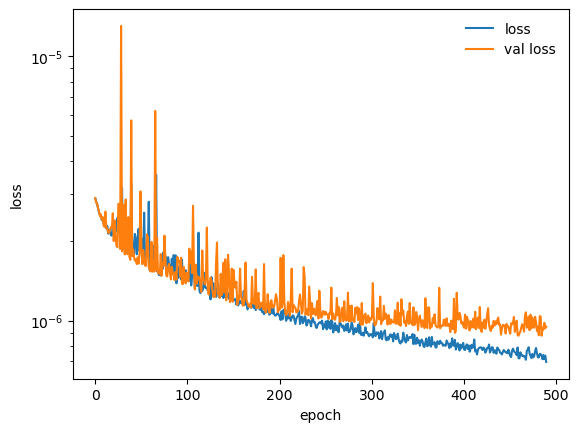

In [17]:
plt.plot(mixed_hist.history['loss'][10:],label="loss")
plt.plot(mixed_hist.history['val_loss'][10:],label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale('log')
plt.legend(frameon=False)

In [18]:
import tensorflow as tf

mixed_efn.save('mixed_efn_var_etaJ.h5')

In [19]:
unseenetaJ_path_list = []

for test_etaJ in range(-30, 31, 1):

    unseenetaJ_path = f'/root/jettiming/ScriptForDecaying/fixed_xt_{x_t}_etaM_{eta_M}/testdata/test_clustered_etaM_{eta_M}_etaJ_{test_etaJ}_xt_{x_t}/processed_delayed_jet'
    unseenetaJ_path_list.append(unseenetaJ_path)

In [20]:
unseen_pTweighted_dict, unseen_input_dict, unseen_label_dict = preprocessing(unseenetaJ_path_list)

In [21]:
unseen_input_keylist = list(unseen_input_dict.keys())
print(unseen_input_keylist)

['input/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/testdata/test_clustered_etaM_0_etaJ_-30_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/testdata/test_clustered_etaM_0_etaJ_-29_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/testdata/test_clustered_etaM_0_etaJ_-28_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/testdata/test_clustered_etaM_0_etaJ_-27_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/testdata/test_clustered_etaM_0_etaJ_-26_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/testdata/test_clustered_etaM_0_etaJ_-25_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/testdata/test_clustered_etaM_0_etaJ_-24_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/testdata/test_clustere

 1/66 [..............................] - ETA: 1s

/tmp/ipykernel_4518/2803418085.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


16/16 [==============================] - 0s 24ms/step


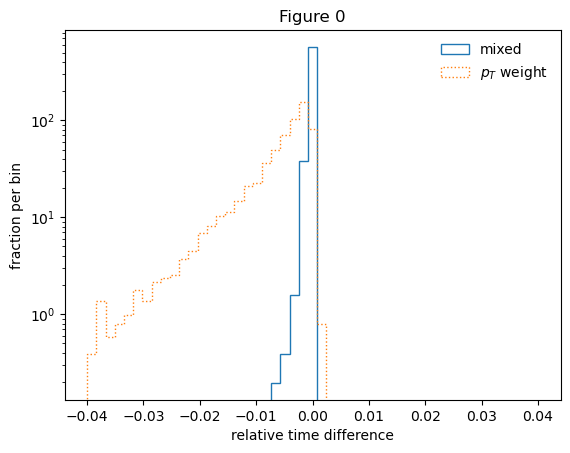

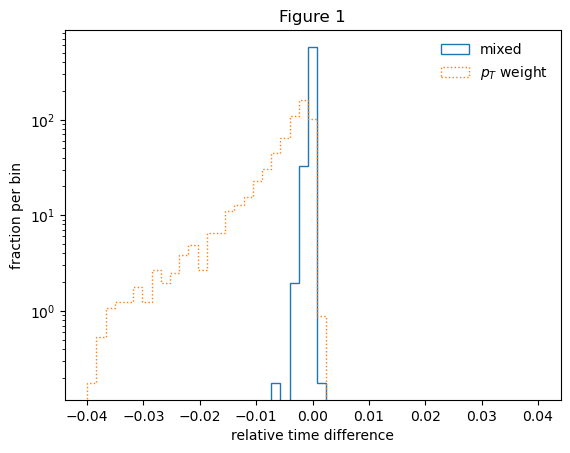

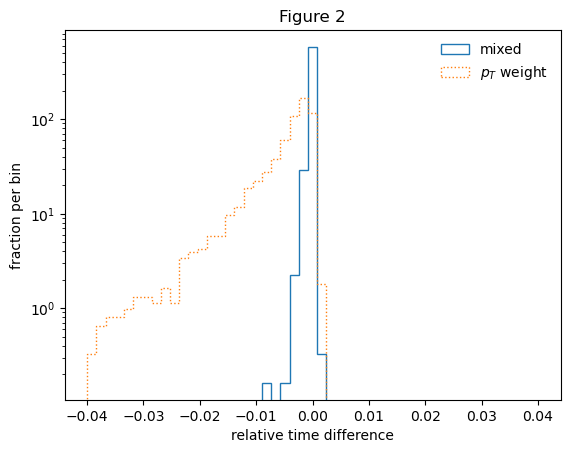

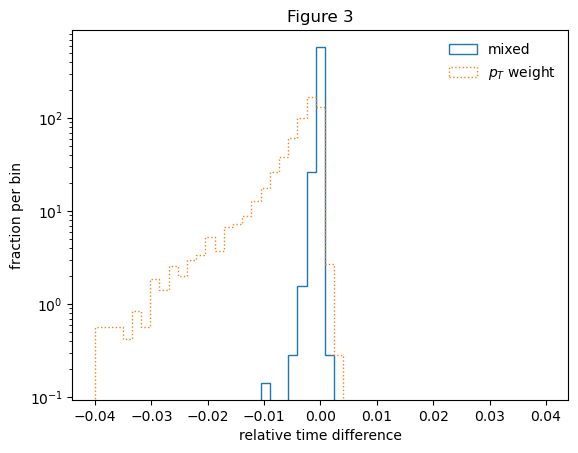

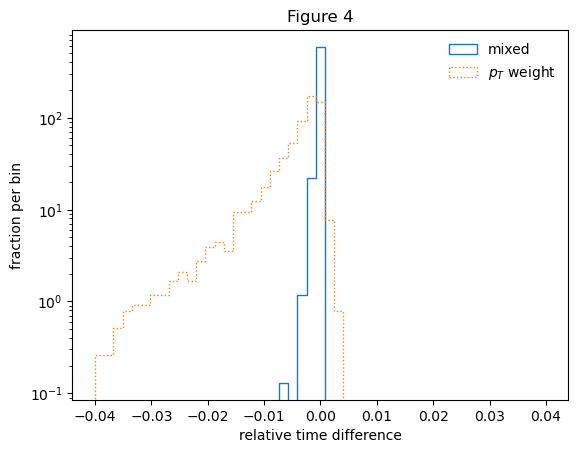

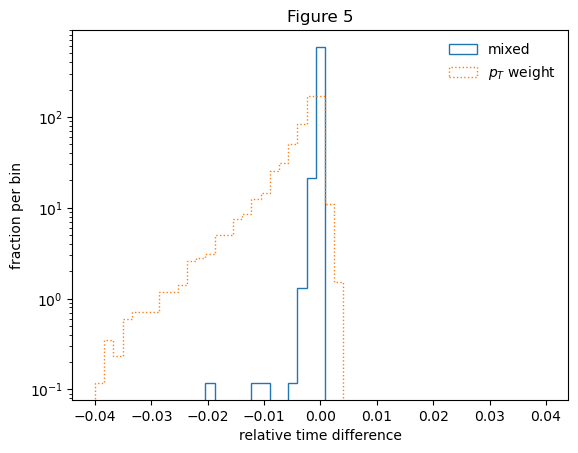

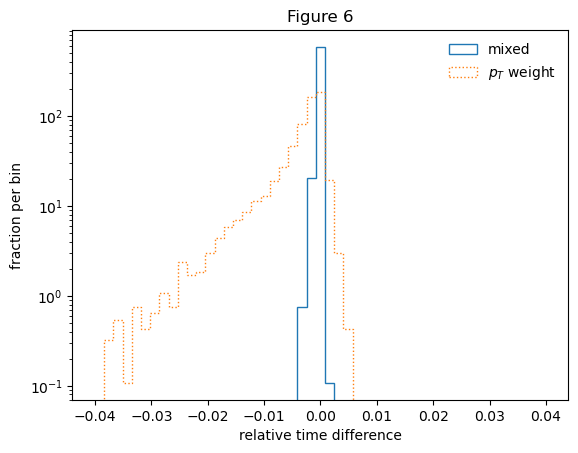

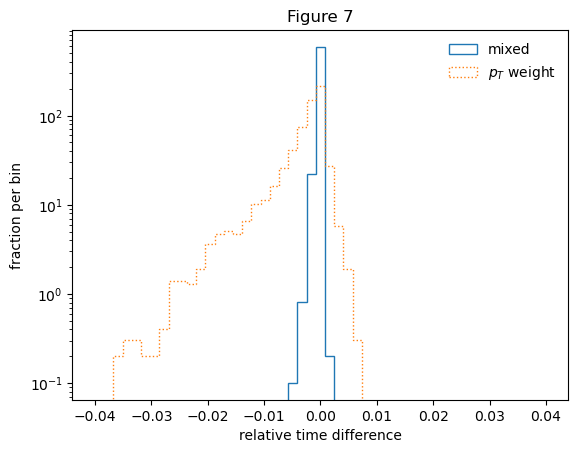

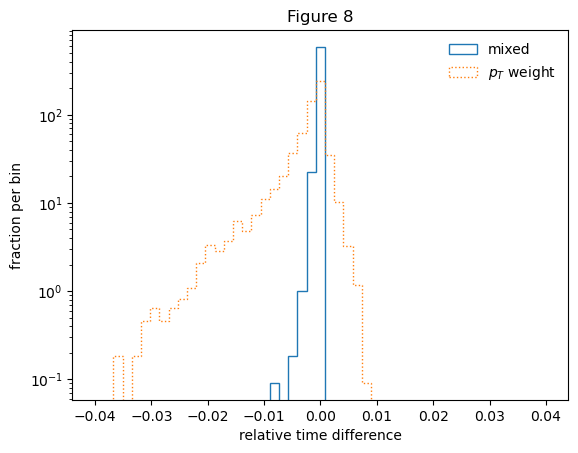

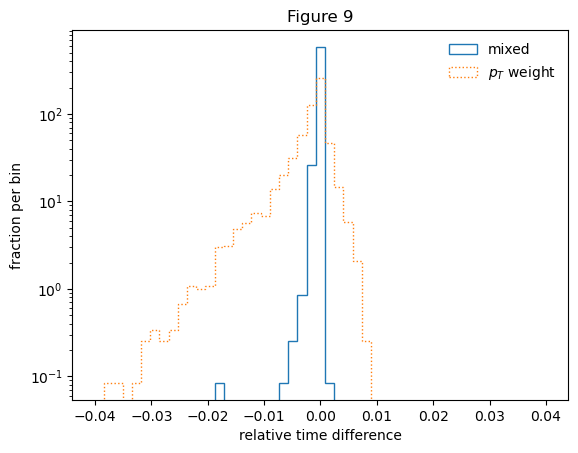

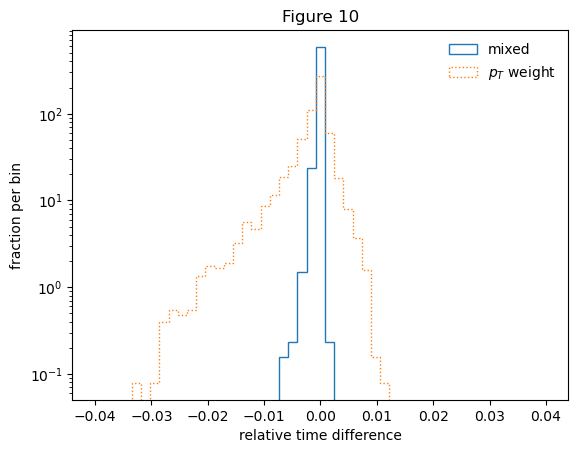

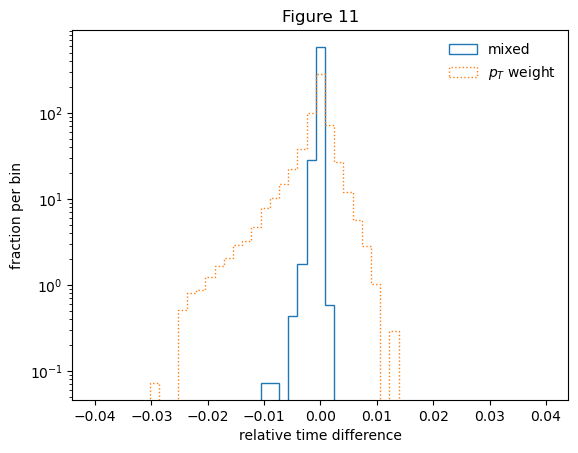

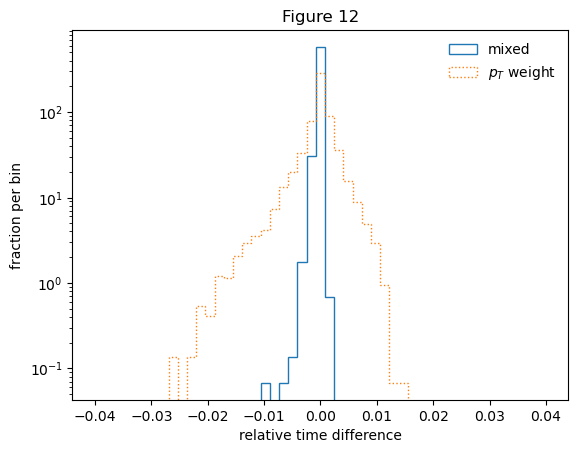

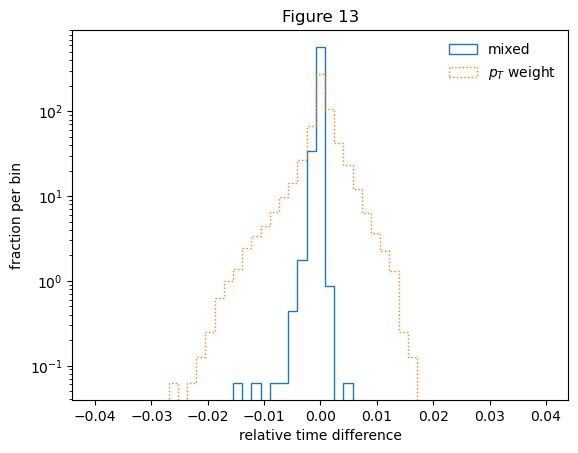

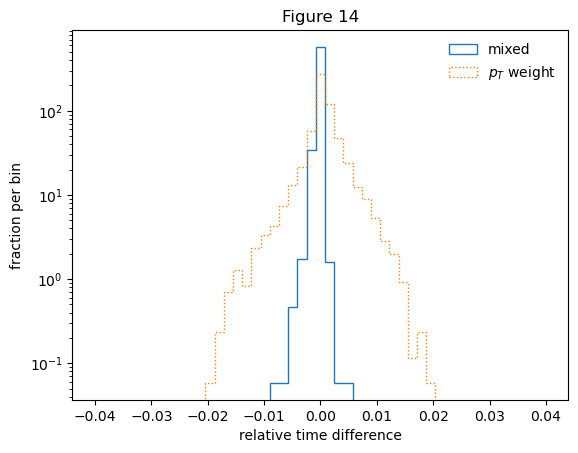

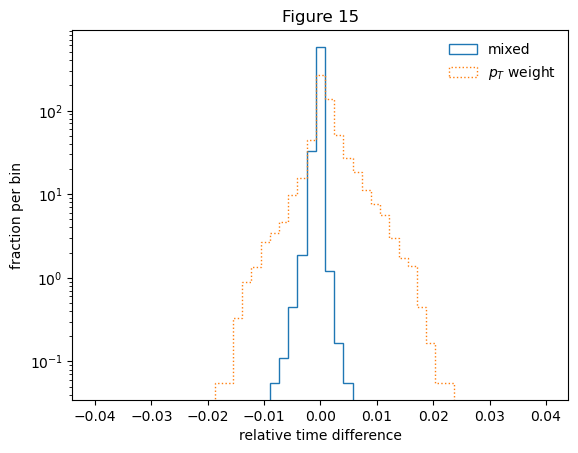

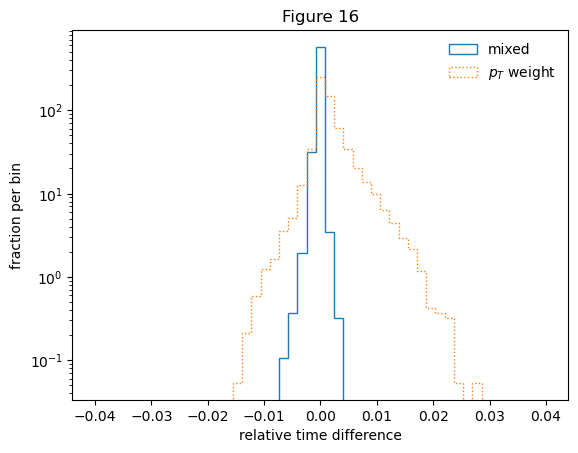

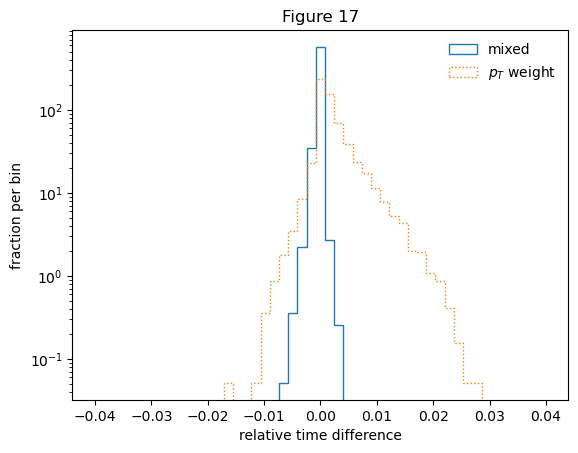

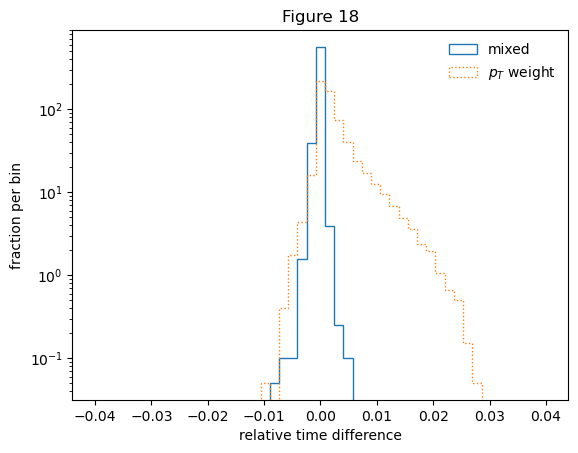

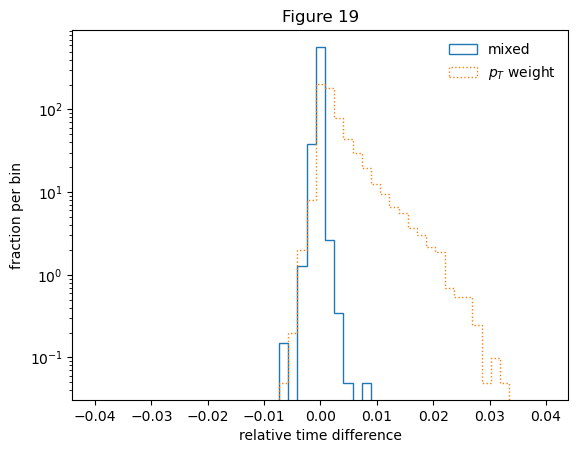

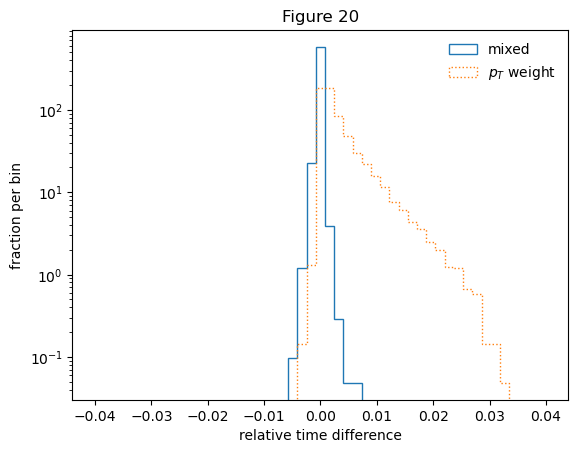

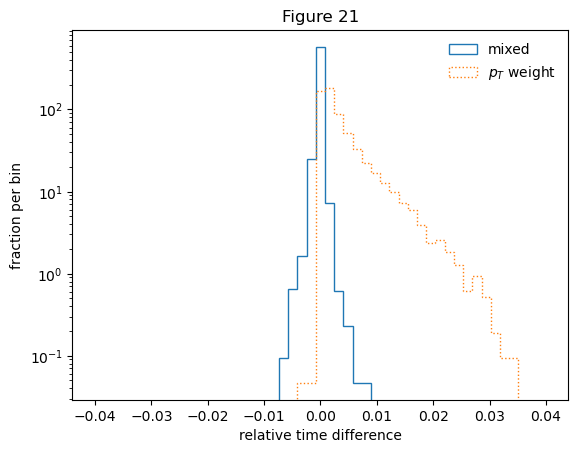

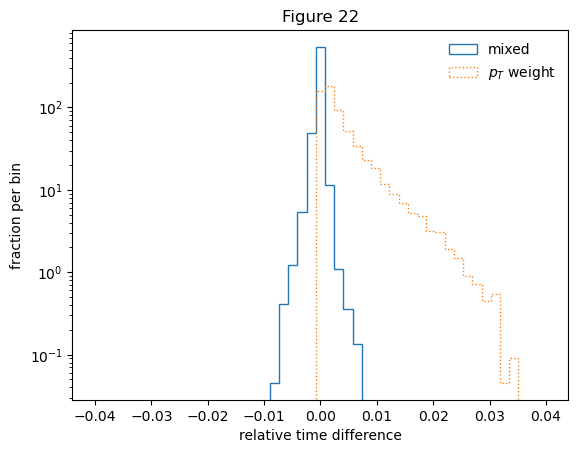

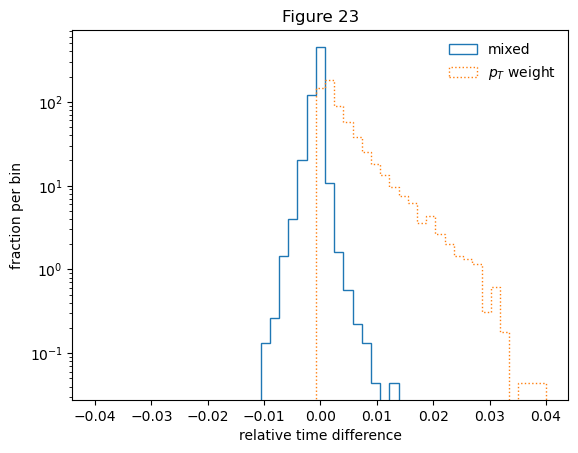

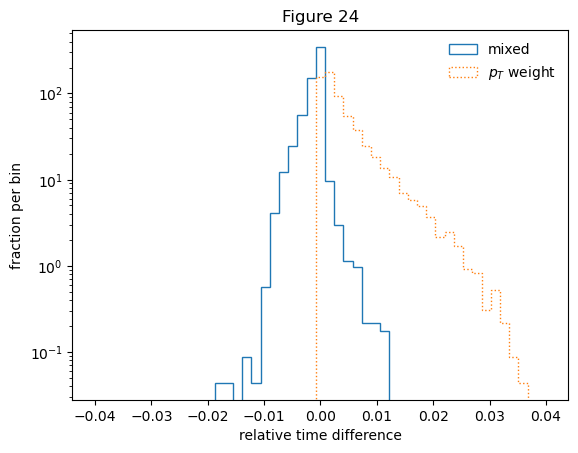

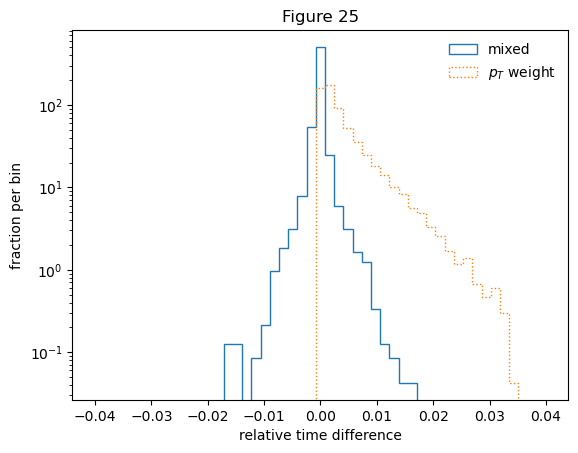

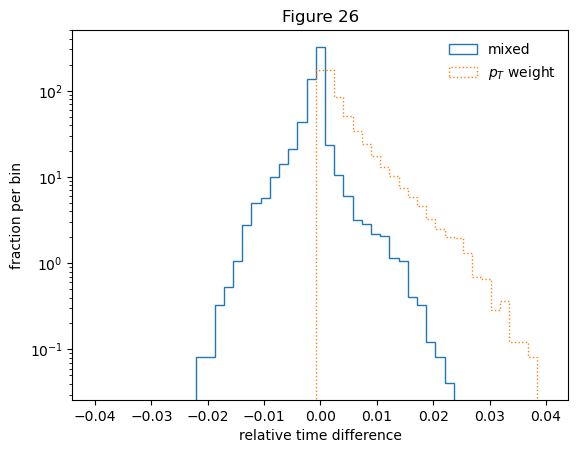

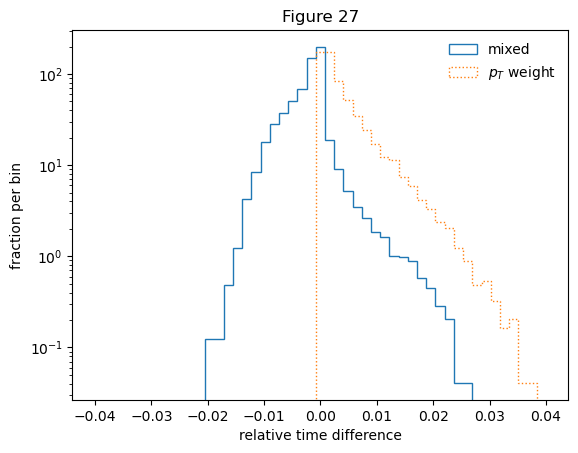

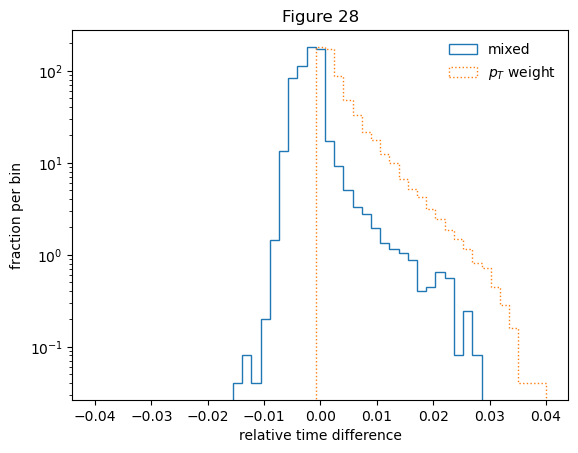

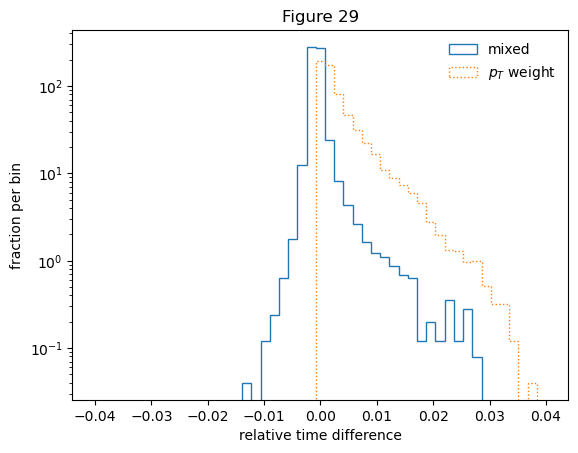

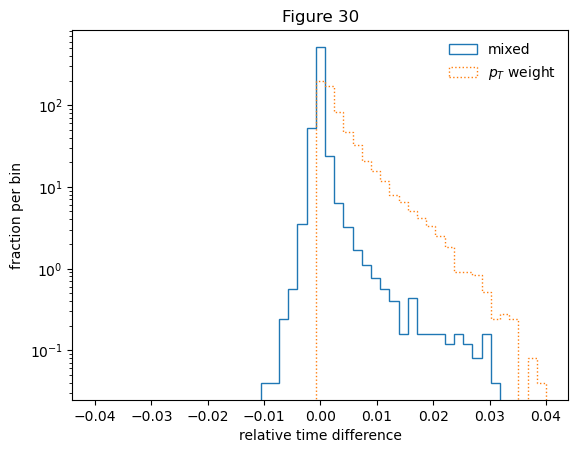

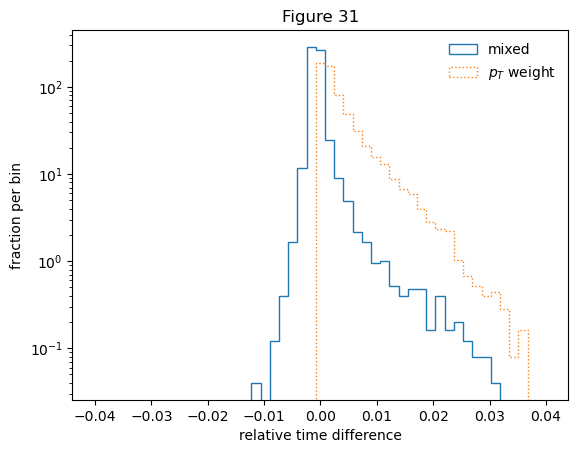

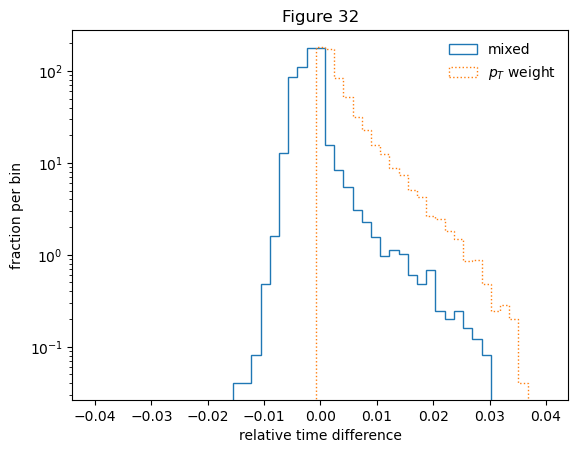

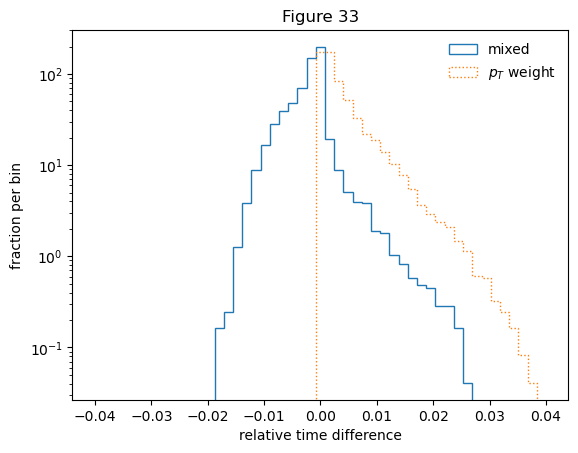

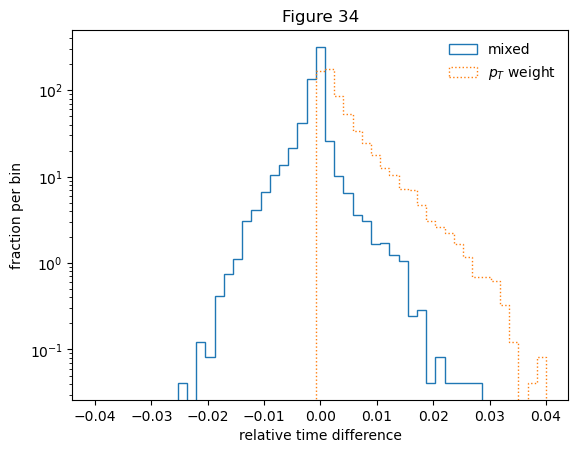

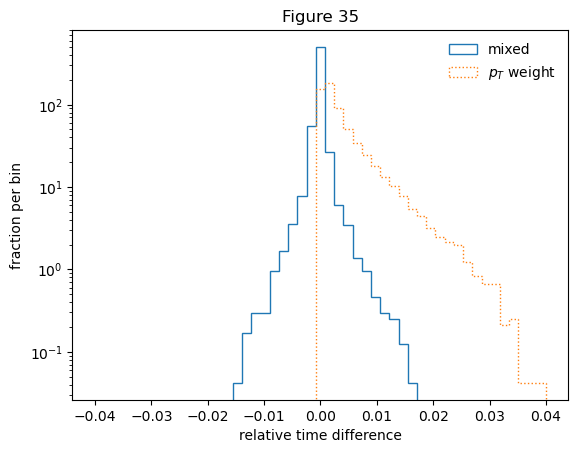

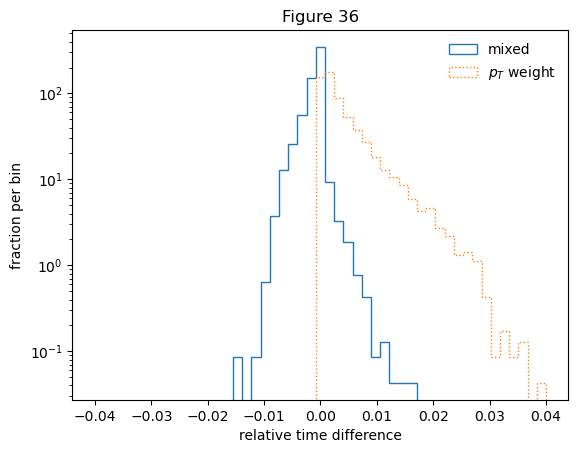

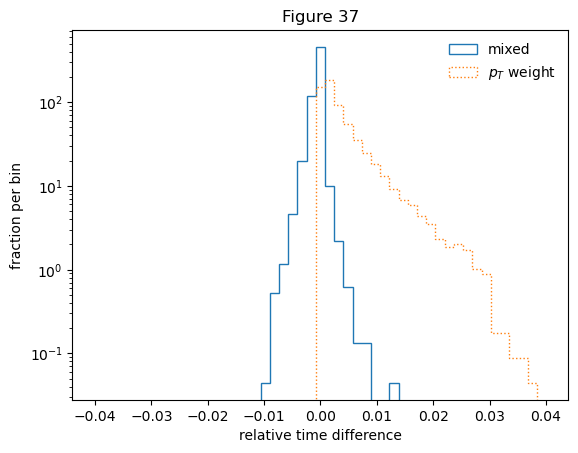

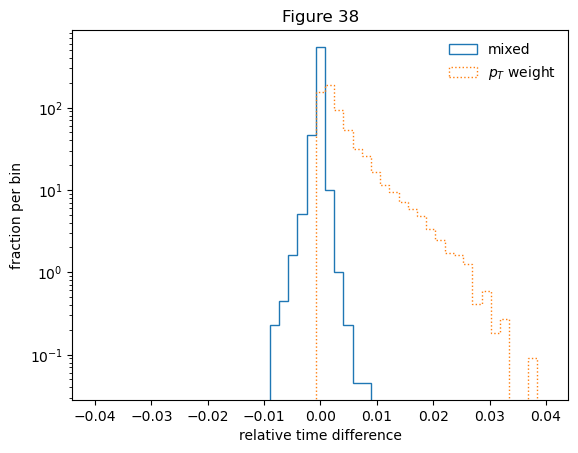

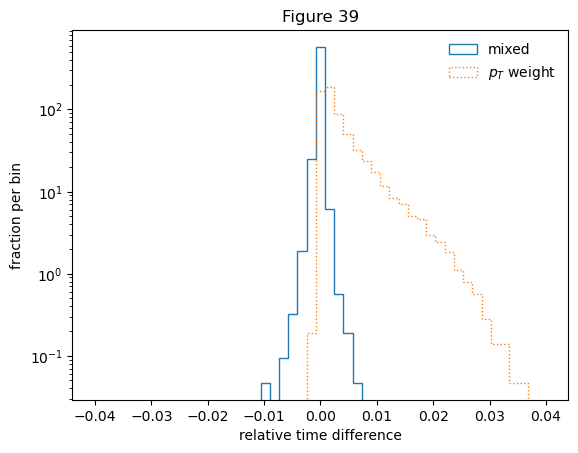

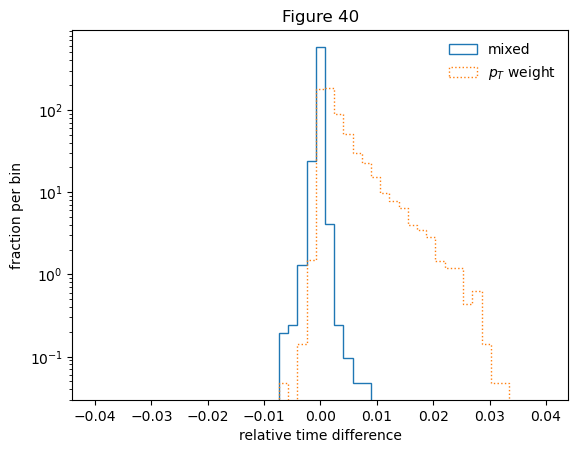

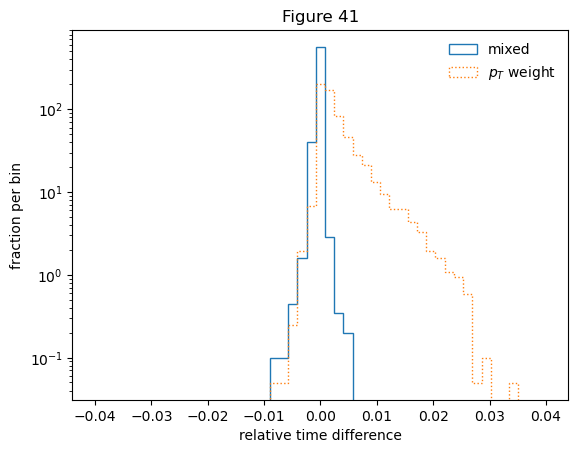

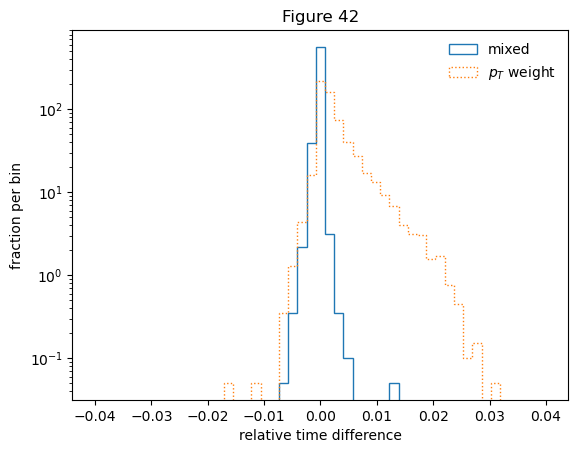

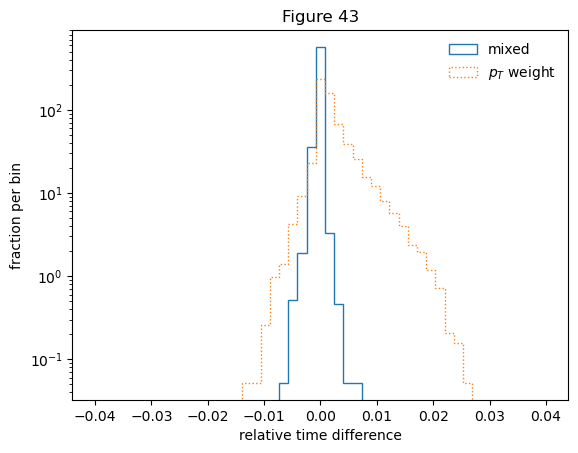

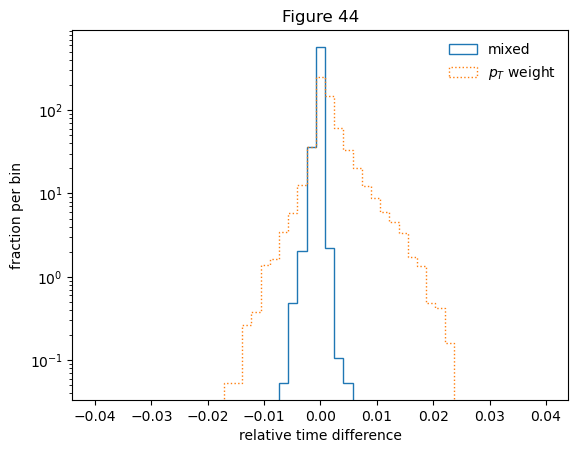

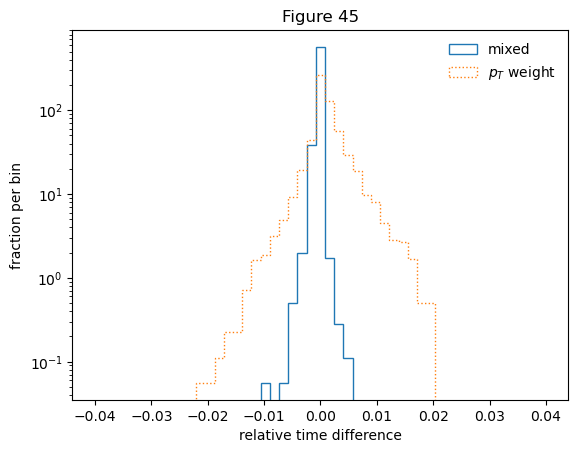

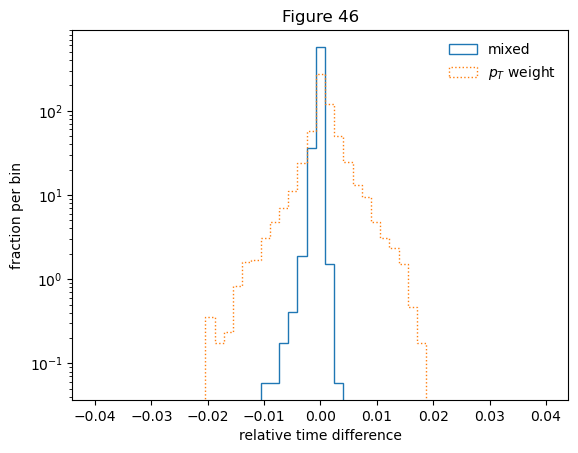

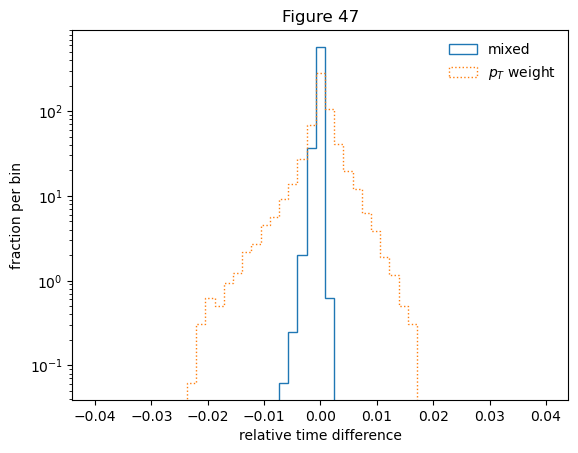

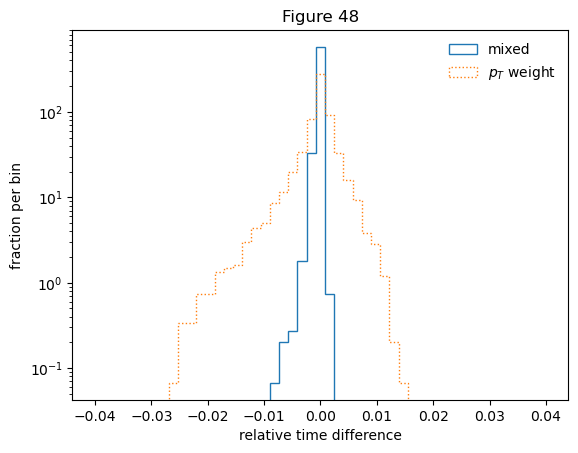

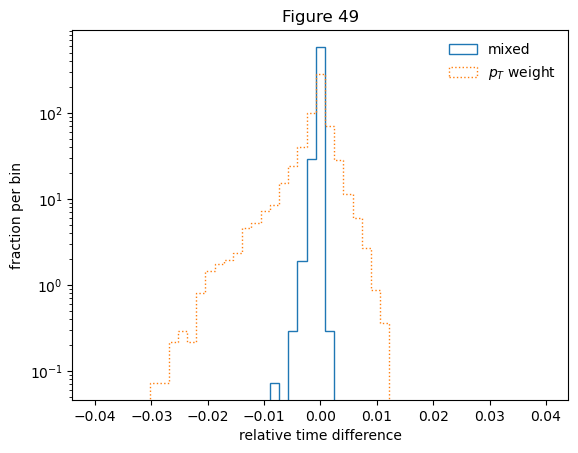

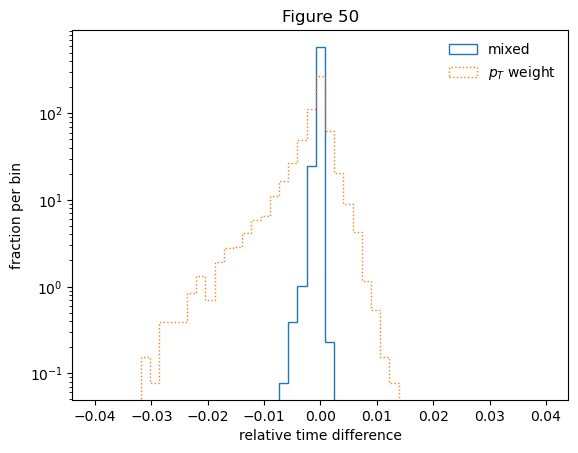

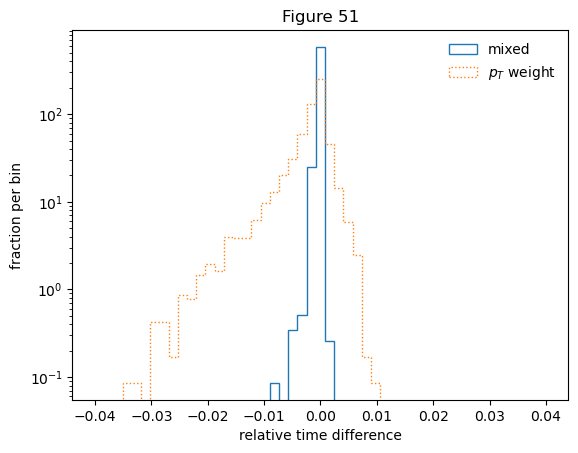

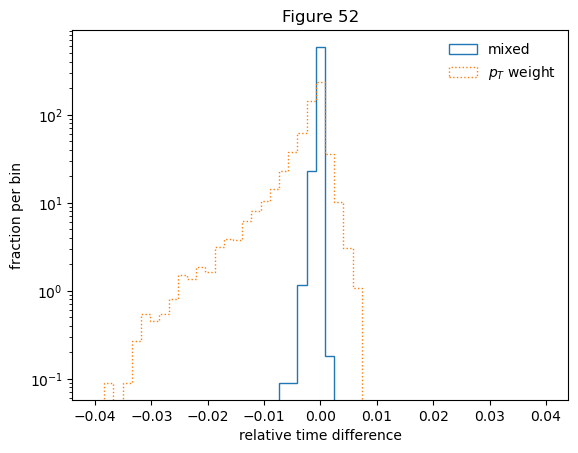

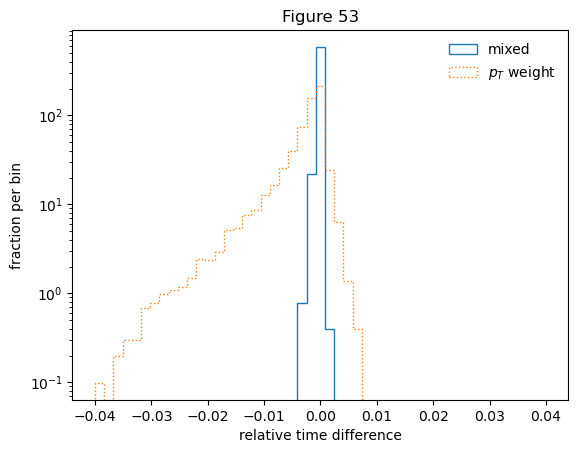

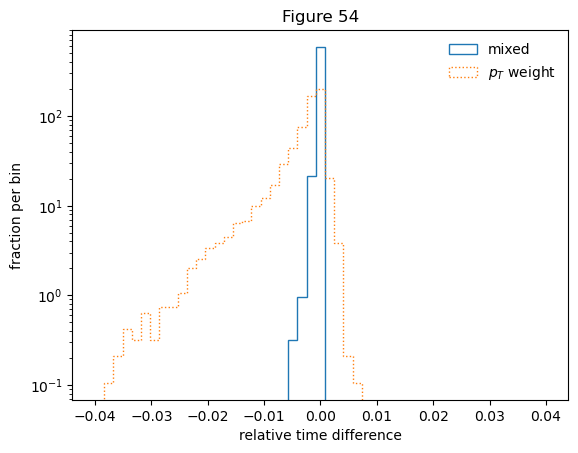

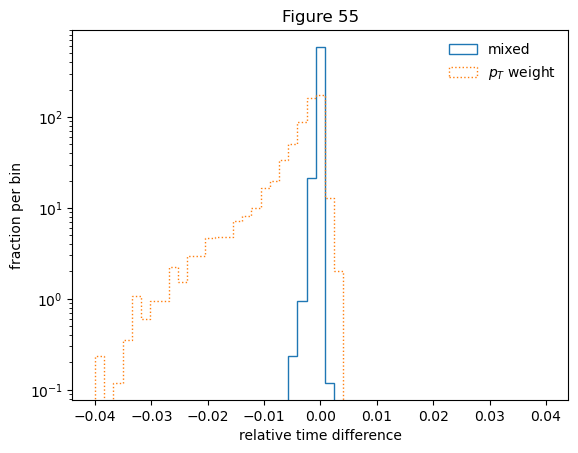

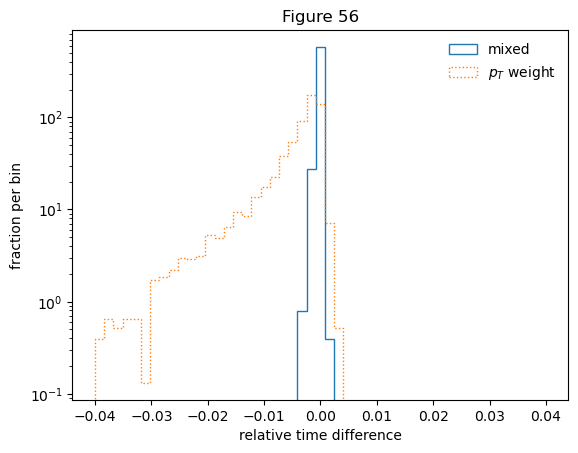

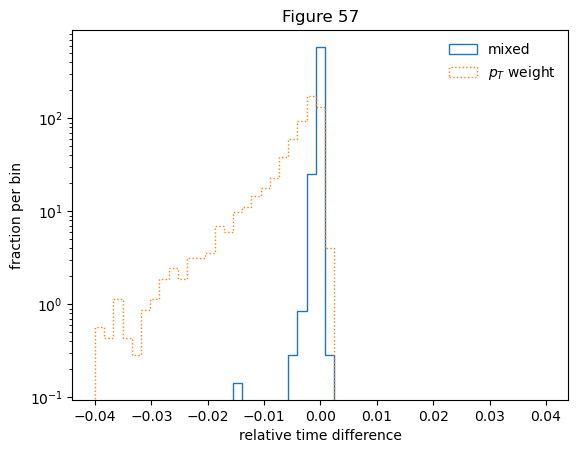

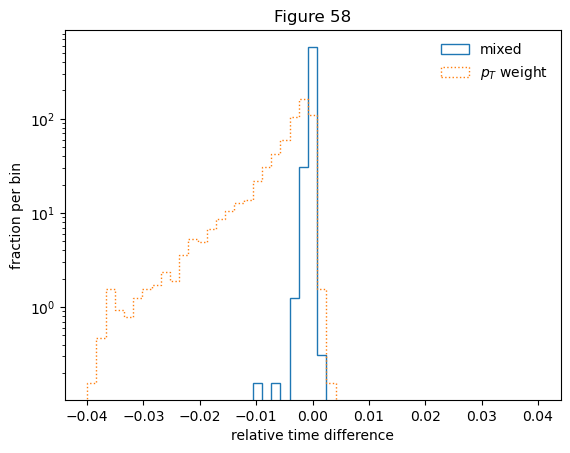

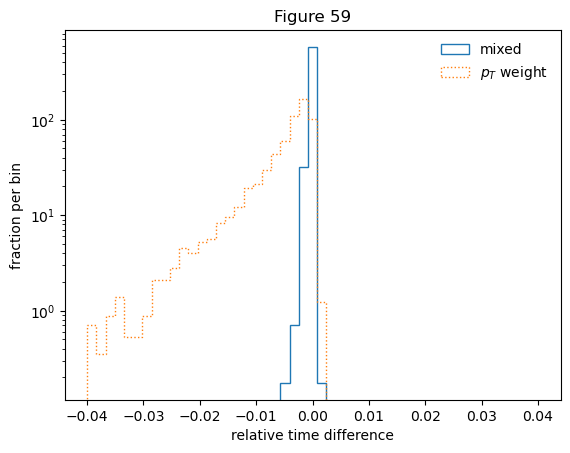

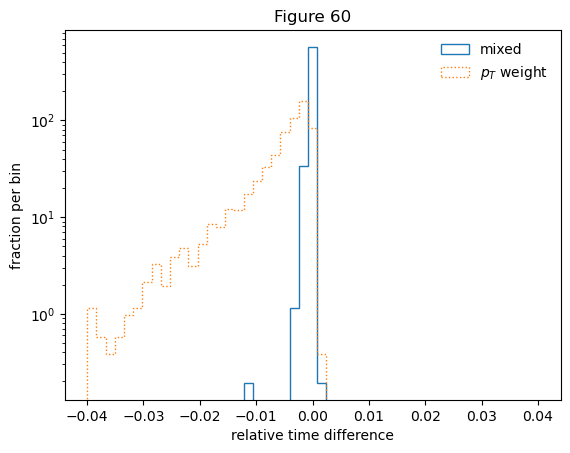

In [22]:
NNpred_list = []
pTpred_list = []

for i, eta_path in enumerate(unseenetaJ_path_list):
    test_z = unseen_input_dict["input"+eta_path][:,:,0]
    test_X = unseen_input_dict["input"+eta_path][:,:,1:]
    test_Y = unseen_label_dict["label"+eta_path]

    preds_unseen_mixed = mixed_efn.predict([test_z,test_X],batch_size=200)
    difference = (preds_unseen_mixed + 1)/(test_Y + 1) - 1
    residuals = 1/(test_Y + 1) - 1

    NNpred_list.append(difference)
    pTpred_list.append(residuals)

    plt.figure()
    plt.hist(difference,bins=np.linspace(-0.04,0.04,50),density=True,histtype="step",label="mixed")
    plt.hist(residuals,bins=np.linspace(-0.04,0.04,50),density=True,histtype="step",label="$p_T$ weight",ls=":")
    plt.yscale("log")
    plt.xlabel("relative time difference")
    plt.ylabel("fraction per bin")
    plt.title(f'Figure {i}')
    plt.legend(frameon=False)
plt.show()


In [23]:
np.save('NNpred_list.npy', NNpred_list)
np.save('pTpred_list.npy', pTpred_list)

/root/miniconda3/envs/madminer/lib/python3.10/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
